# Detection of COVID-19

### Importing Libraries

In [23]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time
import tensorflow as tf
import seaborn as sns

import keras
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.layers import  Flatten, Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
import os 
import cv2

folder1 = "COVID-19_Radiography_Dataset\\COVID\\images"
folder2 = "COVID-19_Radiography_Dataset\\Normal\\images"
folder3 = "COVID-19_Radiography_Dataset\\Viral Pneumonia\\images"

def load_images_from_folder(folder, num):
    images = []
    y = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename));
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = cv2.resize(img,(128,128))
        if img is not None:
            images.append(img)
            y.append(num)
    return images , y

OriginalCovidImages, class1 = load_images_from_folder(folder1,0)
OriginalNormalImages, class3 = load_images_from_folder(folder2,2)
OriginalViralPneumoniaImages, class2 = load_images_from_folder(folder3,1)


In [25]:
def reshapeimages(images, y):
    images = np.array(images)
    y = np.array(y).reshape(-1,1)
    return images, y

### Reshaping the images into numpy array

In [26]:
OriginalCovidImages, class1 = reshapeimages(OriginalCovidImages,class1)
OriginalViralPneumoniaImages, class2 = reshapeimages(OriginalViralPneumoniaImages,class2)
OriginalNormalImages, class3 = reshapeimages(OriginalNormalImages,class3)

print(len(OriginalCovidImages))
print(OriginalCovidImages.shape)
print(class1.shape)

3616
(3616, 128, 128, 3)
(3616, 1)


#### Splitting the covid test data into train/validation/test

In [27]:
Covid_train, Covid_test, class1_train, class1_test = train_test_split(OriginalCovidImages,class1, test_size=0.1, random_state=42)
Covid_test, Covid_val, class1_test, class1_val = train_test_split(Covid_test, class1_test, test_size=0.2, random_state=42)
print(Covid_train.shape)
print(Covid_val.shape)
print(Covid_test.shape)

(3254, 128, 128, 3)
(73, 128, 128, 3)
(289, 128, 128, 3)


#### Splitting the Viral Pneumonia Data into Train/Validation/Test

In [28]:
ViralP_train, ViralP_test, class2_train, class2_test = train_test_split(OriginalViralPneumoniaImages,class2, test_size=0.1, random_state=42)
ViralP_test, ViralP_val, class2_test, class2_val = train_test_split(ViralP_test, class2_test, test_size=0.2, random_state=42)
print(ViralP_train.shape)
print(ViralP_val.shape)
print(ViralP_test.shape)

(1210, 128, 128, 3)
(27, 128, 128, 3)
(108, 128, 128, 3)


#### Splitting the Normal Data into Train/Validation/Test

In [29]:
Normal_train, Normal_test, class3_train, class3_test = train_test_split(OriginalNormalImages,class3, test_size=0.1, random_state=42)
Normal_test, Normal_val, class3_test, class3_val = train_test_split(Normal_test, class3_test, test_size=0.2, random_state=42)
print(Normal_train.shape)
print(Normal_val.shape)
print(Normal_test.shape)

(9172, 128, 128, 3)
(204, 128, 128, 3)
(816, 128, 128, 3)


## Final Train Test Validation set

In [30]:
X_train = np.concatenate((Covid_train, ViralP_train, Normal_train), axis=0) 
y_train = np.concatenate((class1_train, class2_train, class3_train), axis=0) 
X_test = np.concatenate((Covid_test, ViralP_test, Normal_test), axis=0) 
y_test = np.concatenate((class1_test, class2_test, class3_test), axis=0) 
X_val = np.concatenate((Covid_val, ViralP_val, Normal_val), axis=0) 
y_val = np.concatenate((class1_val, class2_val, class3_val), axis=0) 


(13636, 128, 128, 3)

[2]


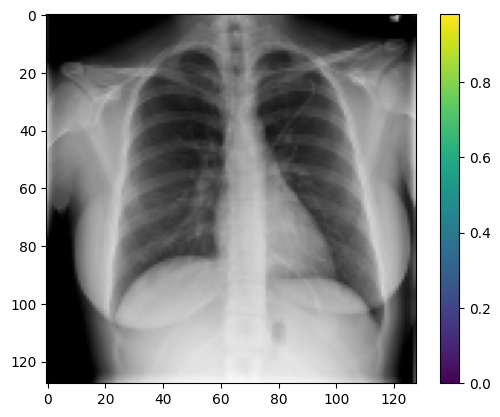

In [41]:
print(X_train.shape)
print()
plt.figure()
plt.imshow(X_train[12300])
plt.colorbar()
plt.grid(False)
plt.show
print(y_train[12300])

In [32]:
X_train = X_train /255
X_test_scaled = X_test / 255
X_val = X_val/255

In [33]:
print(X_train.shape)
print(X_train)

(13636, 128, 128, 3)
[[[[8.04362237e-01 8.04362237e-01 8.04362237e-01]
   [2.38475248e-01 2.38475248e-01 2.38475248e-01]
   [1.60803109e-01 1.60803109e-01 1.60803109e-01]
   ...
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]
   [1.30208337e-03 1.30208337e-03 1.30208337e-03]]

  [[7.00996220e-01 7.00996220e-01 7.00996220e-01]
   [3.55696753e-02 3.55696753e-02 3.55696753e-02]
   [1.46783568e-04 1.46783568e-04 1.46783568e-04]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.28129315e-01 4.28129315e-01 4.28129315e-01]
   [3.39135677e-01 3.39135677e-01 3.39135677e-01]
   [2.71154910e-01 2.71154910e-01 2.71154910e-01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[5.46771228e-01 5.46771228e-01 5.46771228e

In [67]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test= np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)


In [68]:
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [94]:
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# for layer in base_model.layers:
#     layer.trainable=False

# model = Sequential()
# model.add(Conv2D)
# model.add(Flatten())
# model.add(Dense(1024))
# model.add(Activation('relu'))
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(3))
# model.add(Activation('sigmoid'))

from numpy import concatenate
import keras.backend as K

input_shape = (128,128,3)

input_img = tf.keras.Input(shape=input_shape)
# Define the input layer
input_img = tf.keras.Input(shape=input_shape)

# First convolutional layer
Z1 = tf.keras.layers.Conv2D(8, (4, 4), strides=(1, 1), padding="same")(input_img)
A1 = tf.keras.layers.ReLU()(Z1)
P1 = tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=(4, 4), padding="same")(A1)

# Second convolutional layer
Z2 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2, 2), strides=(1, 1), padding="same")(P1)
A2 = tf.keras.layers.ReLU()(Z2)
P2 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding="same")(A2)

# Third convolutional layer
Z3 = tf.keras.layers.Conv2D(32, (4, 4), strides=(1, 1), padding="same")(P2)
A3 = tf.keras.layers.ReLU()(Z3)
P3 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding="valid")(A3)

# Skip Connection Z1
S1 = tf.keras.layers.Conv2D(16,kernel_size=(1,1),strides=(1,1),padding="same")(Z1)
S1_pooled = tf.keras.layers.MaxPool2D(pool_size=(56,56), strides=(8,8),padding = "same")

# Fourth convolutional layer
Z4 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2, 2), strides=(1, 1), padding="same")(P3)
# merge = tf.keras.layers.Concatenate(axis=3)([Z4, S1_pooled])
A4 = tf.keras.layers.ReLU()(Z4)
P4 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding="same")(A4)

F = tf.keras.layers.Flatten()(P4)

D1 = tf.keras.layers.Dense(units = 16, activation="tanh")(F)

outputs = tf.keras.layers.Dense(units=3,activation="softmax")(D1)

model = tf.keras.Model(inputs=input_img, outputs = outputs)
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_77 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_176 (Conv2D)         (None, 128, 128, 8)       392       
                                                                 
 re_lu_121 (ReLU)            (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 32, 32, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_177 (Conv2D)         (None, 32, 32, 16)        528       
                                                                 
 re_lu_122 (ReLU)            (None, 32, 32, 16)        0         
                                                          

In [111]:
from keras.callbacks import EarlyStopping

learning_rate = 0.00001
decay_steps = 10
decay_rate = 1


lr_schedular = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate=lr_schedular)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,y_train, batch_size=32,epochs=40, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/40
427/427 [==============================] - 48s 110ms/step - loss: 0.3587 - accuracy: 0.8612 - val_loss: 0.3552 - val_accuracy: 0.8717
Epoch 2/40
427/427 [==============================] - 47s 110ms/step - loss: 0.3554 - accuracy: 0.8618 - val_loss: 0.3527 - val_accuracy: 0.8750
Epoch 3/40
427/427 [==============================] - 47s 111ms/step - loss: 0.3520 - accuracy: 0.8632 - val_loss: 0.3495 - val_accuracy: 0.8750
Epoch 4/40
427/427 [==============================] - 50s 116ms/step - loss: 0.3488 - accuracy: 0.8655 - val_loss: 0.3454 - val_accuracy: 0.8783
Epoch 5/40
427/427 [==============================] - 48s 113ms/step - loss: 0.3456 - accuracy: 0.8662 - val_loss: 0.3432 - val_accuracy: 0.8750
Epoch 6/40
427/427 [==============================] - 44s 104ms/step - loss: 0.3425 - accuracy: 0.8674 - val_loss: 0.3395 - val_accuracy: 0.8783
Epoch 7/40
427/427 [==============================] - 53s 124ms/step - loss: 0.3394 - accuracy: 0.8677 - val_loss: 0.3366 - val_ac

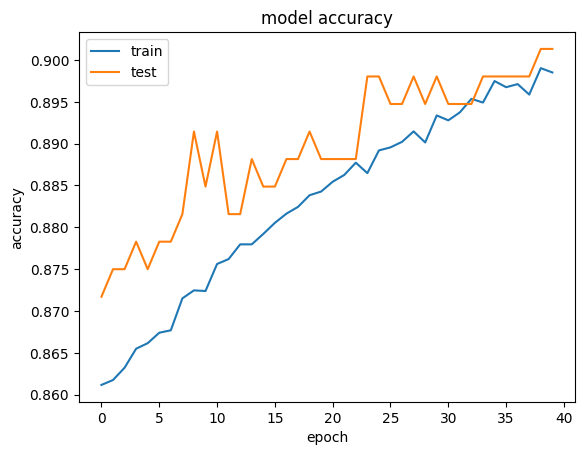

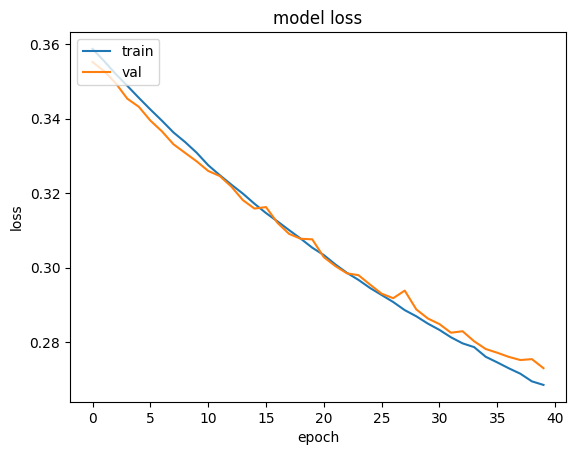

In [112]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [17]:
model.save('model3.h5')

In [18]:
model1 = load_model('model3.h5')

In [113]:
y_hat = model.predict(X_test_scaled)

38/38 [==============================] - 2s 31ms/step


In [114]:
print(y_hat)

[[5.4535764e-01 4.9512004e-03 4.4969115e-01]
 [6.6805887e-01 5.3332742e-02 2.7860838e-01]
 [7.5268650e-01 2.0961214e-02 2.2635239e-01]
 ...
 [1.5964955e-02 2.2508282e-02 9.6152681e-01]
 [4.0431865e-02 2.9818751e-04 9.5926988e-01]
 [4.2345547e-03 1.2909606e-04 9.9563640e-01]]


In [115]:
y_pred = y_hat.round()
print(y_pred)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [116]:
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [117]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.8854080791426217


In [119]:
labels = ['Covid', 'Viral Pneumonia', 'Normal']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
print(f"Accuracy: {accuracy}")

                 precision    recall  f1-score   support

          Covid       0.81      0.78      0.79       289
Viral Pneumonia       0.94      0.82      0.88       108
         Normal       0.92      0.93      0.93       816

      micro avg       0.90      0.89      0.89      1213
      macro avg       0.89      0.84      0.87      1213
   weighted avg       0.90      0.89      0.89      1213
    samples avg       0.89      0.89      0.89      1213

Accuracy: 0.8854080791426217


c:\Users\Naziya Mahimkar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[230   1  58]
 [ 10  89   9]
 [ 50   5 761]]


([<matplotlib.axis.XTick at 0x1c2e7ca10a0>,
 [Text(0.5, 0, 'Covid'),
  Text(1.5, 0, 'Viral Pneumonia'),
  Text(2.5, 0, 'Normal')])

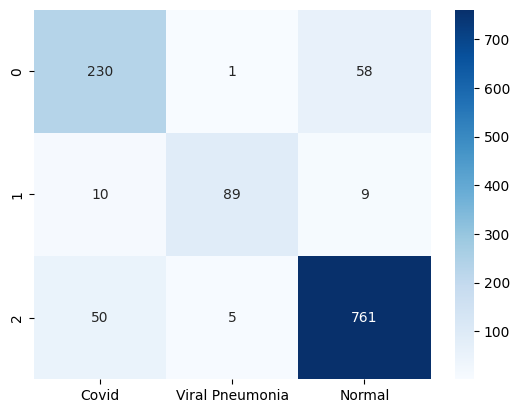

In [120]:
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

tick_labels = ['Covid', 'Viral Pneumonia', 'Normal']
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
